<a href="https://colab.research.google.com/github/harshithavutukuru/brain_tumor_cnn/blob/main/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG-DIR'] = '/content/kaggle.json'

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "harshithavutukuru"
os.environ['KAGGLE_KEY'] = "37e0c6e97ac58d5051647aee93a2571b"


In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 87% 93.0M/107M [00:00<00:00, 149MB/s]
100% 107M/107M [00:00<00:00, 138MB/s] 


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import zipfile

with zipfile.ZipFile('brian-tumor-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [ ]:
import os

filename = 'metadata.csv'
if os.path.exists(filename):
    print(f"The file '{filename}' exists.")
else:
    print(f"The file '{filename}' does not exist.")


The file 'metadata.csv' does not exist.


In [ ]:
import os

filename = '/content/dataset/metadata.csv'
if os.path.exists(filename):
    print(f"The file '{filename}' exists.")
else:
    print(f"The file '{filename}' does not exist.")


The file '/content/dataset/metadata.csv' exists.


In [ ]:
file_name = "metadata.csv"  # Replace "your_dataset_file.csv" with the actual filename
current_directory = os.getcwd()
# Get the full path of the file
file_path = os.path.join(current_directory, file_name)

# Print the full path of the file
print("Full path of the dataset file:", file_path)


Full path of the dataset file: /content/metadata.csv


In [ ]:
import pandas as pd
df = pd.read_csv('/content/dataset/metadata.csv')
df

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...,...
4595,4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

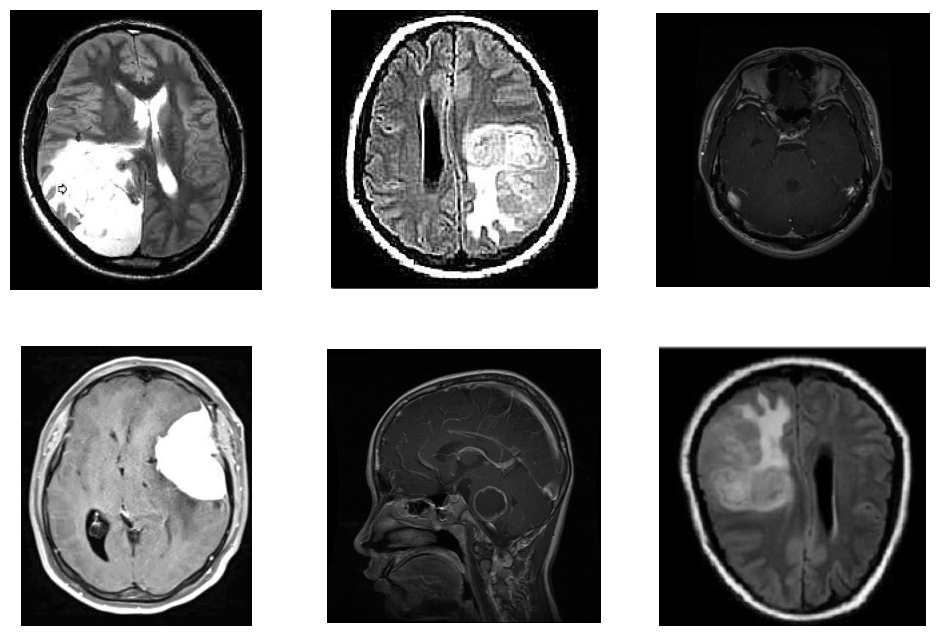

In [ ]:
# Brain Tumor Images - Visualizing in grid layout
folder_path = '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

num_images = min(6, len(image_files_tumor))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(folder_path, image_files_tumor[i])
    img = mpimg.imread(image_path)
    # print(img.shape)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

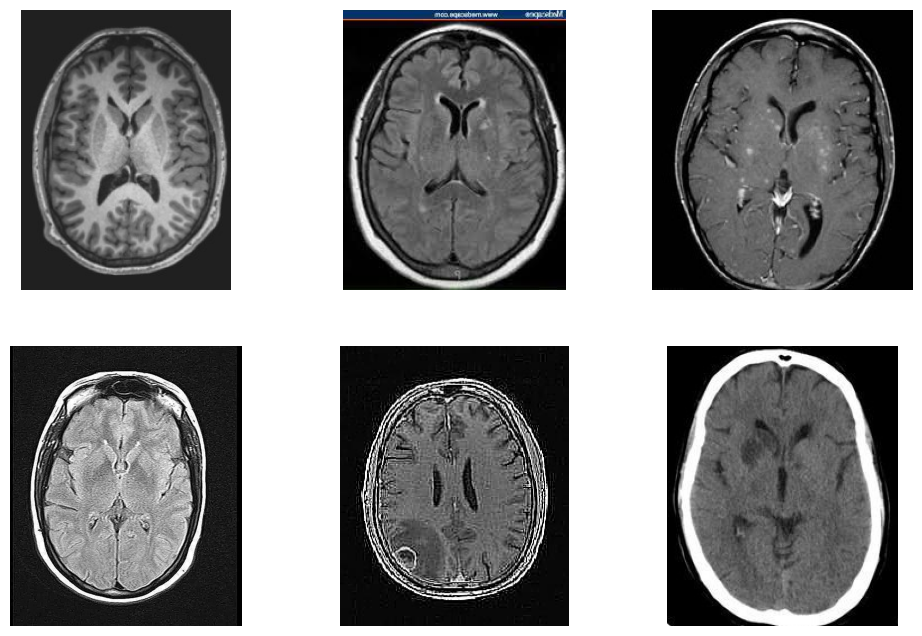

In [ ]:
# Healthy Images - Visualizing in grid layout
folder_path = '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
image_files_healthy = [file for file in os.listdir(folder_path)]
num_images = min(6, len(image_files_healthy))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(folder_path, image_files_healthy[i])
    img = mpimg.imread(image_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [ ]:
print("Number of Tumor Images in the directory:",len(image_files_tumor))
print("Number of Healthy Images in the directory:",len(image_files_healthy))

Number of Tumor Images in the directory: 2513
Number of Healthy Images in the directory: 2087


## **Image Data Generator**

In [ ]:
# Define the image size and batch size
img_height, img_width = 224, 224
batch_size = 512

# Create an ImageDataGenerator object
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    validation_split=0.2,  # reserve some images for validation
)

# Load the training dataset

train_dataset = datagen.flow_from_directory(
    '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='training',
)

# Load the validation dataset
validation_dataset = datagen.flow_from_directory(
    '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='validation',
)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


## **Graph Plotting Function**

In [ ]:
# plot metrics
def plot_metrics(history):
    metrics = ["loss", "accuracy", "prc", "Precision", "Recall"]
    plt.figure(figsize=(16, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()

        plt.subplot(3,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(True)

        # Adjust y-axis limits for better visualization
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

        plt.legend()

## **CNN Model**

In [ ]:
def build_model(metrics, epoch = 20):
    # Clear any previous model session to start fresh
    tf.keras.backend.clear_session()

    # Initialize a Sequential model
    model = tf.keras.models.Sequential()

    # Add a 2D convolution layer with 16 filters, a 3x3 kernel, and 'relu' activation function
    model.add(tfl.Conv2D(16, (3, 3), activation='relu', padding = "same", input_shape=(img_height, img_width, 1)))

    # Add a max pooling layer to reduce the spatial dimensions of the output volume
    model.add(tfl.MaxPooling2D((2, 2)))

    # Add another convolution and max pooling layer
    model.add(tfl.Conv2D(8, (3, 3), activation='relu', padding = "same"))
    model.add(tfl.MaxPool2D((2,2)))

    # Flatten the tensor output from the previous layer to create a single long feature vector
    model.add(tfl.Flatten())

    # Add a dense layer with 8 neurons and 'relu' activation function
    model.add(tfl.Dense(8, activation='relu'))

    # Add batch normalization layer to normalize the activations of the previous layer
    model.add(tfl.BatchNormalization())

    # Add a dropout layer to prevent overfitting
    model.add(tfl.Dropout(0.3))

    # Add the output layer with a single neuron (for binary classification) and 'sigmoid' activation function
    model.add(tfl.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    model.summary()

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch, verbose=1)

    plot_metrics(history)

    # Return the trained model and its history
    return model, history

In [ ]:
# Define the metrics for the model to judge on
metrics = [ tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.F1Score(name='F1'),
            tf.keras.metrics.Recall(name='Recall'),
            tf.keras.metrics.Precision(name='Precision'),
            tf.keras.metrics.AUC(name='prc', curve='PR')]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

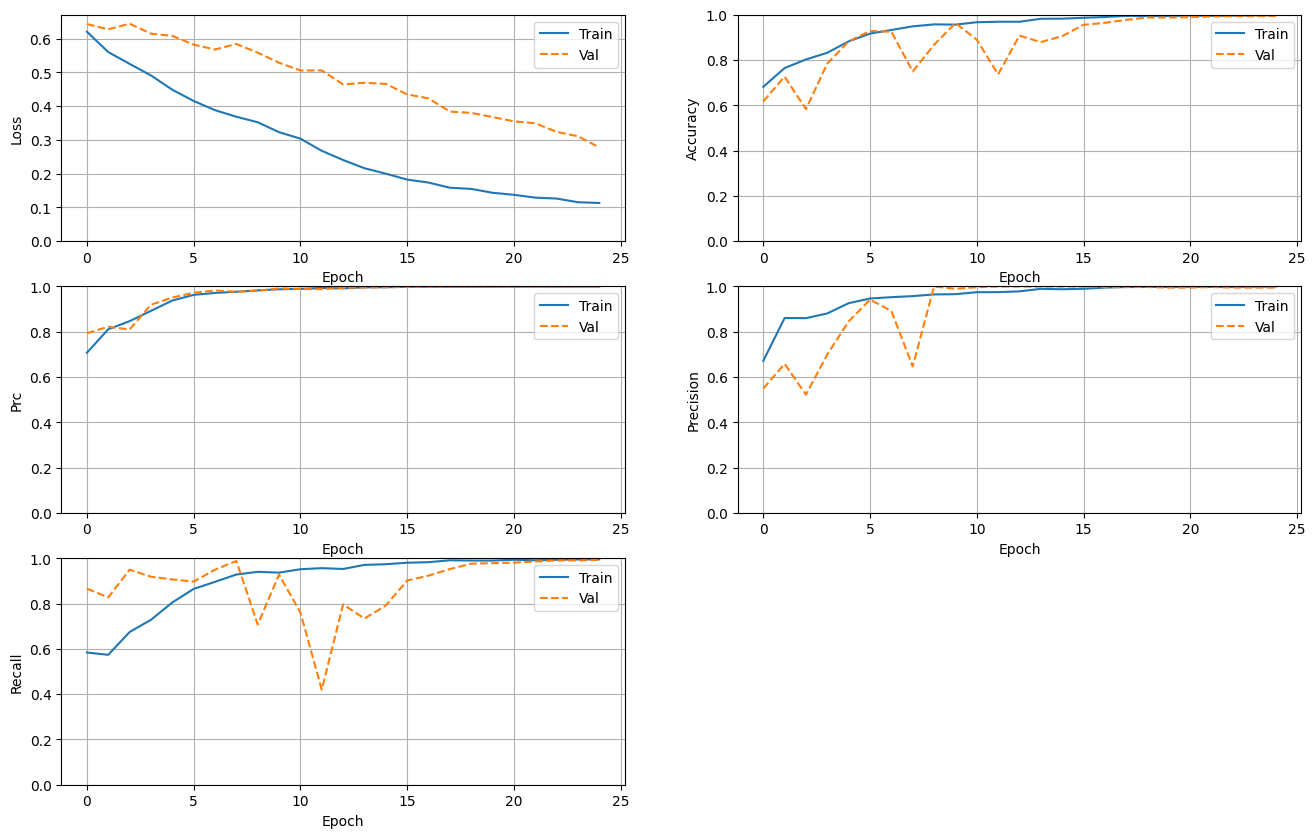

In [ ]:
model, history = build_model(metrics, epoch = 25)

In [ ]:
model.evaluate(validation_dataset)

2/2 [==============================] - 11s 3s/step - loss: 0.2777 - accuracy: 0.9946 - F1: 0.6243 - Recall: 0.9928 - Precision: 0.9952 - prc: 0.9998


[0.2777402102947235,
 0.9945592880249023,
 array([0.6242515], dtype=float32),
 0.9928057789802551,
 0.995192289352417,
 0.9998213052749634]

In [ ]:
# getting labels of the validation_dataset for plotting confusion matrix
steps = validation_dataset.samples // validation_dataset.batch_size
if validation_dataset.samples % validation_dataset.batch_size > 0:
    steps += 1

images_list = []
y_true = []

for i, (images, labels) in enumerate(validation_dataset):
    if i >= steps:
        break
    images_list.extend(images)
    y_true.extend(labels)

images_array = np.array(images_list)
y_true = np.array(y_true)

## **Predictions**

29/29 [==============================] - 9s 297ms/step


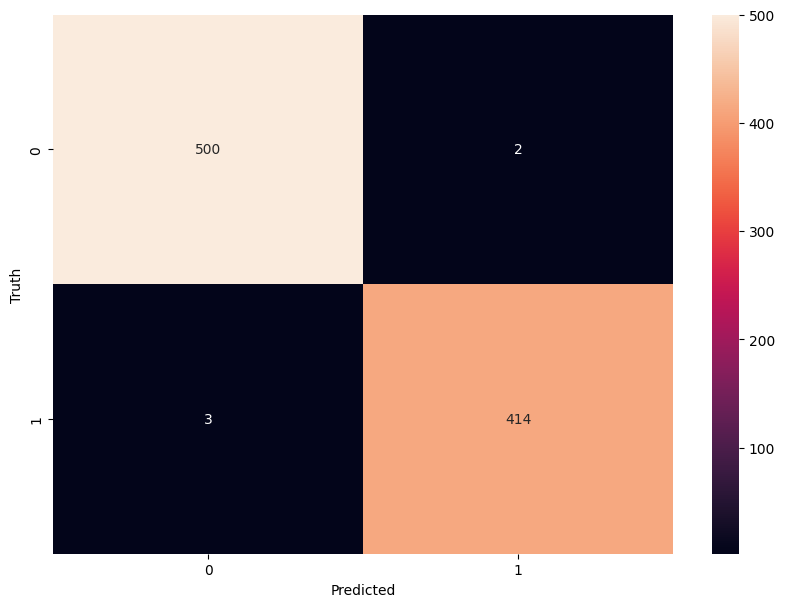

In [ ]:
# getting predictions
y_pred = model.predict(images_array)
y_pred = (y_pred >= 0.5).astype(int)
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## **Classification Report**

In [ ]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       502
         1.0       1.00      0.99      0.99       417

    accuracy                           0.99       919
   macro avg       0.99      0.99      0.99       919
weighted avg       0.99      0.99      0.99       919



### **SVM Classifier**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import os
folder_path = os.listdir('/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/')
classes = {'Healthy':0, 'Brain Tumor':1}



In [ ]:
import cv2

X =[]
Y = []
for cls in classes:
  pth = '/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j,0)
    img = cv2.resize(img,(200,200))
    X.append(img)
    Y.append(classes[cls])

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
np.unique(Y)

array([0, 1])

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
pd.Series(Y).value_counts()

1    2513
0    2087
Name: count, dtype: int64

In [ ]:
X.shape

(4600, 200, 200)

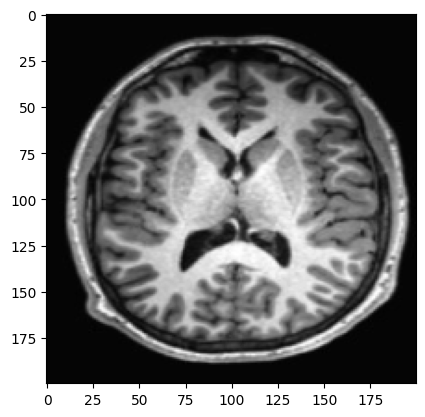

In [ ]:
plt.imshow(X[0],cmap='gray')

In [ ]:
X_updated = X.reshape(len(X),-1)
X_updated.shape

(4600, 40000)

## **Training and Testing data split**

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10, test_size=.20)

In [ ]:
xtrain.shape, xtest.shape

((3680, 40000), (920, 40000))

## **Feature Sclaing**

In [ ]:
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())

xtrain = xtrain/255
xtest = xtest/255

print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())


255 0
255 0
1.0 0.0
1.0 0.0


## **Feature selection: PCA**

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
print(xtrain.shape, xtest.shape)
pca = PCA(.98)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
pca_train = xtrain
pca_test = xtest


(3680, 40000) (920, 40000)


In [ ]:
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# lg = LogisticRegression(C=0.1)
# lg.fit(pca_train, ytrain)


In [ ]:
sv = SVC()
sv.fit(pca_train, ytrain)

SVC()

In [ ]:
# Assuming you have training data `X_train` and corresponding labels `y_train`
sv.fit(xtrain, ytrain)
print("Training Score: ", sv.score(pca_train, ytrain))
print("testing Score: ", sv.score(pca_test, ytest))


Training Score:  0.975
testing Score:  0.9619565217391305


In [ ]:
pred = sv.predict(pca_test)
np.where(ytest!=pred)



(array([104, 147, 163, 188, 221, 227, 253, 266, 274, 279, 292, 299, 326,
        339, 358, 380, 414, 437, 443, 472, 526, 538, 571, 629, 641, 651,
        706, 747, 761, 762, 794, 806, 813, 827, 875]),)

In [ ]:
pred[6]

0

In [ ]:
ytest[6]

0

In [ ]:
dec = {0:'Healthy', 1:'Brain Tumor'}

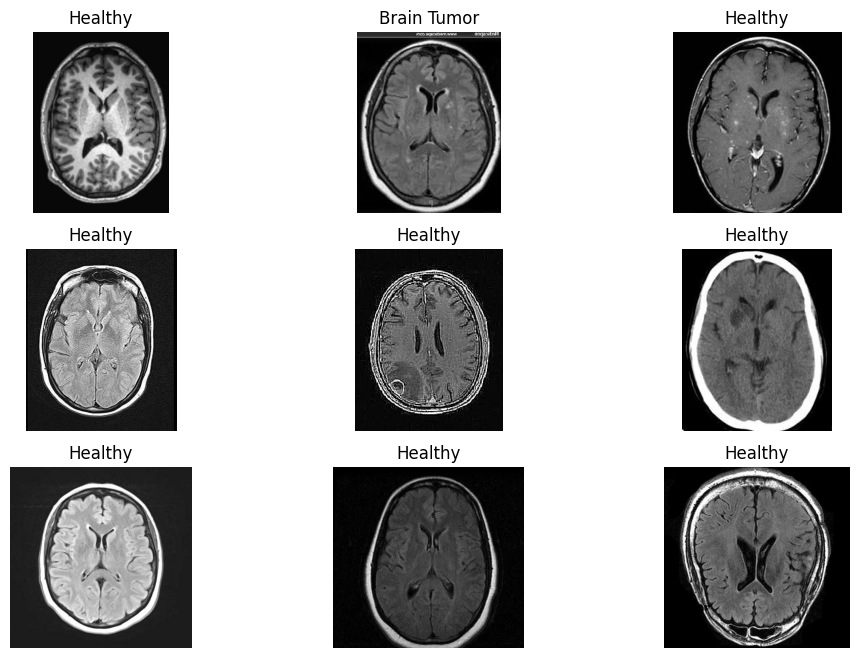

In [ ]:
plt.figure(figsize=(12,8))
p = os.listdir('/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/')
c=1
for i in os.listdir('/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/')[:9]:
    plt.subplot(3,3,c)

    img = cv2.imread('/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'+i,0)
    img1 = cv2.resize(img, (200,200))
    img1 = img1.reshape(1,-1)/255
    p = sv.predict(img1)
    plt.title(dec[p[0]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c+=1

In [ ]:
# import cv2
# import os
# file_path = os.path.join('/content/dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/', i)

# try:
#   img = cv2.imread(file_path,0)
#   if img is None:
#     raise FileNotFoundError(f"Failed to read image at path: {file_path}")
#   img1 = cv2.resize(img, (200, 200))
#   img1 = img1.reshape(1, -1) / 255
#   p = sv.predict(img1)
# except Exception as e:
#     print(f"Error occurred: {e}")


## **Predictions**

In [ ]:
sv_score = sv.score(pca_test, ytest)


0.9619565217391305


In [ ]:
print(sv_score)

0.9619565217391305
